### Load data

In [2]:
# Install and load the required package if not already installed
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}
library(readr)

# Define the file paths for all CSV files
file_paths <- c("trips_import_2020-06.csv", "trips_import_2020-05.csv")

# Initialize an empty dataframe
trips <- data.frame()

# Loop through each file, read it, and append to the trips dataframe
for (file_path in file_paths) {
  temp_df <- read_csv(file_path)
  trips <- rbind(trips, temp_df)
}

# View the first few rows of the combined dataframe
head(trips)

Rows: 345277 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (21): trip_distance, RatecodeID, extra, tip_amount, total_amount, pickup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 208593 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (21): trip_distance, RatecodeID, extra, tip_amount, total_amount, pickup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trip_distance,RatecodeID,extra,tip_amount,total_amount,pickuptime_in_seconds,trip_duration,pickup_weekday,PULocationID_encoded,DOLocationID_encoded,⋯,pickup_is_weekend,trip_log_duration,trip_log_distance,trip_duration_squared,trip_distance_squared,duration_log_interaction,duration_distance_squared_interaction,trip_duration_cubed,trip_distance_cubed,duration_distance_cubed_interaction
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.60,1,3.0,4.00,19.3,1883,1115,Monday,15.97617,13.80704,⋯,0,7.017506,1.526056,1243225,12.9600,25.26302,16112196.0,1386195875,46.656000,64674354744
5.60,1,3.0,2.00,23.3,2570,1303,Monday,15.39873,26.66805,⋯,0,7.173192,1.887070,1697809,31.3600,40.16987,53243290.2,2212245127,175.616000,388505640223
2.30,1,0.5,0.00,11.3,2391,558,Monday,13.68903,18.22794,⋯,0,6.326149,1.193922,311364,5.2900,14.55014,1647115.6,173741112,12.167000,2113908110
5.30,1,3.0,0.00,21.3,3373,925,Monday,13.38711,18.22794,⋯,0,6.830874,1.840550,855625,28.0900,36.20363,24034506.2,791453125,148.877000,117829166891
4.40,1,3.0,3.65,18.3,1001,769,Monday,15.24436,13.24517,⋯,0,6.646391,1.686399,591361,19.3600,29.24412,11448749.0,454756609,85.184000,38737986981
1.72,1,0.5,0.00,11.8,389,413,Monday,13.83188,12.93527,⋯,0,6.025866,1.000632,170569,2.9584,10.36449,504611.3,70444997,5.088448,358455704


### Draw correlation heatmap

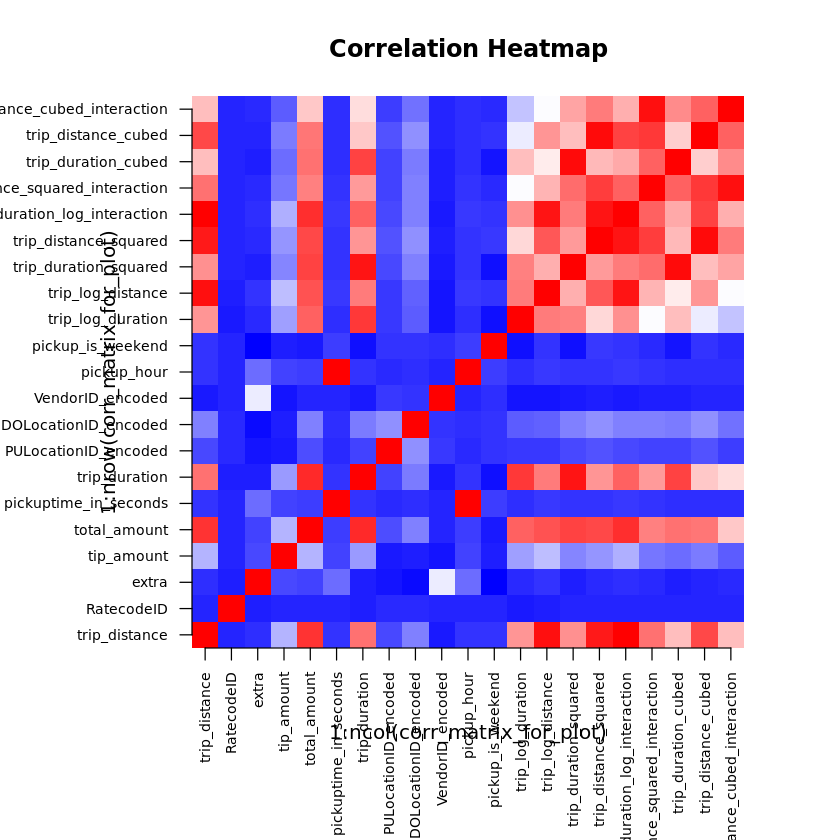

In [3]:
# Step 1: Identify numeric columns
numeric_cols <- trips[, sapply(trips, is.numeric)]

# Step 2: Calculate the correlation matrix
corr_matrix <- cor(numeric_cols)

# Step 3: Reshape the correlation matrix manually (melt) without using additional libraries
corr_matrix_melt <- data.frame(
  Var1 = rep(rownames(corr_matrix), each = ncol(corr_matrix)),
  Var2 = rep(colnames(corr_matrix), times = nrow(corr_matrix)),
  value = as.vector(corr_matrix)
)

# Step 4: Create the heatmap using base R's image() function
# Reshape the correlation matrix into a matrix for plotting
corr_matrix_for_plot <- as.matrix(corr_matrix)

# Define color palette for heatmap
color_palette <- colorRampPalette(c("blue", "white", "red"))(100)

# Set up the plot layout to have extra space for axis labels
par(mar = c(8, 8, 4, 4))  # Increase the margins to fit the labels outside the plot

# Plot the heatmap
image(1:ncol(corr_matrix_for_plot), 1:nrow(corr_matrix_for_plot), corr_matrix_for_plot, 
      col = color_palette, axes = FALSE, main = "Correlation Heatmap")

# Add axis labels  with adjusted positions
# Horizontal axis
axis(1, at = 1:ncol(corr_matrix_for_plot), labels = colnames(corr_matrix_for_plot), las = 2, cex.axis = 0.7)
# Vertical axis 
axis(2, at = 1:nrow(corr_matrix_for_plot), labels = rownames(corr_matrix_for_plot), las = 2, cex.axis = 0.7)


Apart from polinomial variables there are other highly correlated variables such as pickup_hour (with total amount), trip duration (with total amount), trip_distance. <br>

In [8]:
# Create the pickup_is_weekend column based on pickup_weekday
trips$pickup_is_weekend <- ifelse(trips$pickup_weekday %in% c("Saturday", "Sunday"), 1, 0)

# Now create the interaction column
trips$pickuptime_weekend_interaction <- trips$pickup_is_weekend * trips$pickuptime_in_seconds

trips$log_total_amount <- log(trips$total_amount)

In [9]:
# Set the seed for reproducibility
set.seed(123)

# Get the indices of the dataset
dt_index <- 1:nrow(trips)

# Sample 80% of the indices
smpl_index <- sample(dt_index, size = floor(0.8 * length(dt_index)), replace = FALSE)

# Create the training set using the sampled indices
dt_train <- trips[smpl_index, ]

# Create the test set by excluding the sampled indices
dt_test <- trips[-smpl_index, ]

# Reset the index for the training set (reset row names in R)
rownames(dt_train) <- NULL

# Print the lengths of the datasets
cat("Length of training set:", nrow(dt_train), "\n")
cat("Length of test set:", nrow(dt_test), "\n")


Length of training set: 443096 
Length of test set: 110774 


In [10]:
# Get all column names from the 'trips' dataframe
column_names <- names(dt_train)

# Print the column names
print(column_names)

 [1] "trip_distance"                        
 [2] "RatecodeID"                           
 [3] "extra"                                
 [4] "tip_amount"                           
 [5] "total_amount"                         
 [6] "pickuptime_in_seconds"                
 [7] "trip_duration"                        
 [8] "pickup_weekday"                       
 [9] "PULocationID_encoded"                 
[10] "DOLocationID_encoded"                 
[11] "VendorID_encoded"                     
[12] "pickup_hour"                          
[13] "pickup_is_weekend"                    
[14] "trip_log_duration"                    
[15] "trip_log_distance"                    
[16] "trip_duration_squared"                
[17] "trip_distance_squared"                
[18] "duration_log_interaction"             
[19] "duration_distance_squared_interaction"
[20] "trip_duration_cubed"                  
[21] "trip_distance_cubed"                  
[22] "duration_distance_cubed_interaction"  
[23] "pick

Variables included: <br>
- RatecodeID
- pickuptime_weekend_interaction - i think pickup time should play significant role here. Added interaction on weekends because it is expected to have a higher price on weekends
- trip_log_duration, trip_duration_cubed - polinomial terms form trip_duration because trip_duration is highly correlated with total_amount but should be significant for predictions. After trying various combinations, these two combined work better.
- PU/DU locations
- VendorID

In [13]:
# Define Independent variables
column_names <- c( "RatecodeID", 
                  "pickuptime_weekend_interaction",
                  "DOLocationID_encoded", "VendorID_encoded", "PULocationID_encoded",
                  "trip_log_duration", 
                  "trip_duration_squared", 
                  "trip_distance_squared",
                 "trip_log_distance")

# Define the dependent variable (target)
dependent_variable <- "log_total_amount"


# Step 3: Create the formula for the linear regression
formula <- as.formula(paste(dependent_variable, "~", paste(column_names[column_names != dependent_variable], collapse = " + ")))

# Step 4: Fit the linear regression model
model <- lm(formula, data = dt_train)

# Step 5: View the summary of the model
print(summary(model))




Call:
lm(formula = formula, data = dt_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.31183 -0.03041  0.00997  0.05956  2.64781 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     7.550e-01  4.251e-03 177.597   <2e-16 ***
RatecodeID                      1.315e-02  4.744e-04  27.716   <2e-16 ***
pickuptime_weekend_interaction -2.919e-07  9.217e-09 -31.666   <2e-16 ***
DOLocationID_encoded           -7.395e-05  3.093e-05  -2.391   0.0168 *  
VendorID_encoded                5.482e-03  2.092e-04  26.208   <2e-16 ***
PULocationID_encoded            8.394e-04  3.458e-05  24.277   <2e-16 ***
trip_log_duration               2.063e-01  5.286e-04 390.264   <2e-16 ***
trip_duration_squared           1.534e-07  7.048e-10 217.568   <2e-16 ***
trip_distance_squared           4.978e-03  4.197e-05 118.627   <2e-16 ***
trip_log_distance               2.399e-01  1.018e-03 235.550   <2e-16 ***
---
Signif. codes:  0

### Calculate VIF's

In [14]:
calculate_vif <- function(model) {
  # Get the model matrix (X)
  X <- model.matrix(model)
  
  # Initialize a vector to store the VIFs
  vif_values <- numeric(ncol(X) - 1)  # Exclude intercept column
  
  for (i in 2:ncol(X)) {  
    temp_model <- lm(X[, i] ~ X[, -i])
    r_squared <- summary(temp_model)$r.squared  # Extract the R-squared value
    vif_values[i - 1] <- 1 / (1 - r_squared) # Calculate the VIF for this variable
  }
  
  # Return a data frame with VIF values
  vif_data <- data.frame(Variable = colnames(X)[-1], VIF = vif_values)  # Exclude intercept
  return(vif_data)
}

vif_results <- calculate_vif(model)
print(vif_results)


                        Variable      VIF
1                     RatecodeID 1.001333
2 pickuptime_weekend_interaction 1.010620
3           DOLocationID_encoded 1.114848
4               VendorID_encoded 1.004347
5           PULocationID_encoded 1.060804
6              trip_log_duration 3.552720
7          trip_duration_squared 2.949052
8          trip_distance_squared 4.302618
9              trip_log_distance 5.254247


### Predict on fitted model and visualize

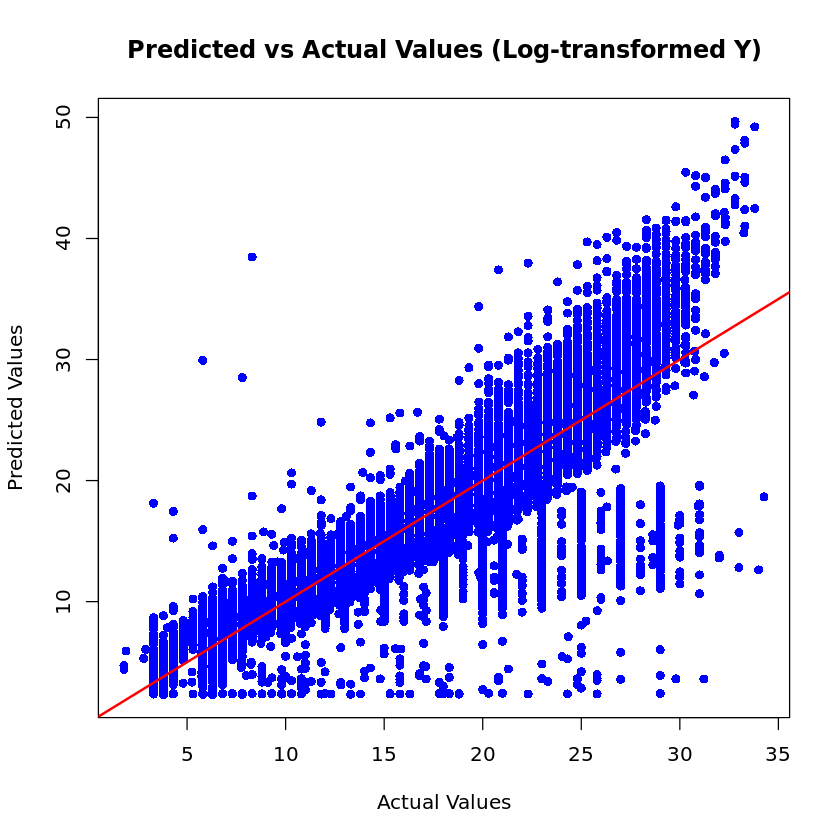

In [19]:
predictions_log <- predict(model, newdata = dt_test)

# Adjust predictions to the original scale by applying exp (since the log was taken)
predictions <- exp(predictions_log)
actual_values <- dt_test$total_amount

# Plot the predicted vs actual values
plot(actual_values, predictions,
     main = "Predicted vs Actual Values (Log-transformed Y)",
     xlab = "Actual Values",
     ylab = "Predicted Values",
     col = "blue",
     pch = 16)
abline(0, 1, col = "red", lwd = 2) 


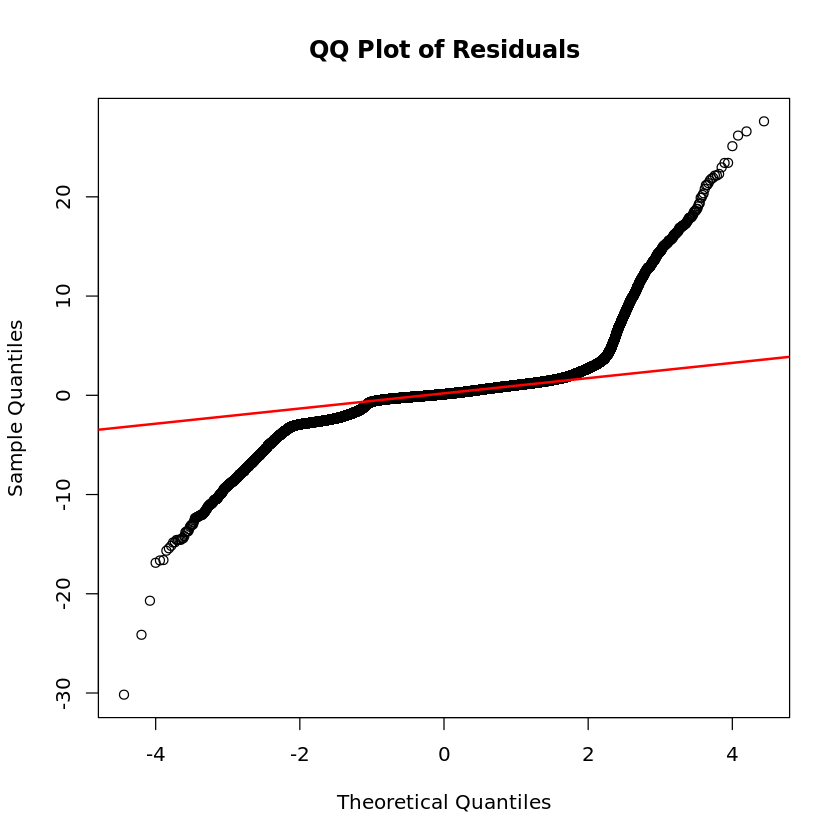

In [20]:
# Step 1: Make predictions on the test set
predictions_log <- predict(model, newdata = dt_test)

# Step 2: Convert predictions back to the original scale
predictions <- exp(predictions_log)

# Step 3: Calculate residuals (actual - predicted)
actual_values <- dt_test$total_amount
residuals <- actual_values - predictions

# Step 4: Create a QQ plot for the residuals
qqnorm(residuals, 
       main = "QQ Plot of Residuals", 
       xlab = "Theoretical Quantiles", 
       ylab = "Sample Quantiles")
qqline(residuals, col = "red", lwd = 2)  # Add a reference line


In [26]:
# Define bootstrap function for linear regression
bootstrap_validation <- function(data, formula, n_iter = 1000) {
  # Store results of bootstrap iterations
  bootstrap_results <- data.frame(R_squared = numeric(n_iter), 
                                  MSE = numeric(n_iter), 
                                  RMSE = numeric(n_iter))
  
  # Set seed for reproducibility
  set.seed(123)
  
  for (i in 1:n_iter) {
    # Create a bootstrap sample (resample with replacement)
    bootstrap_sample <- data[sample(nrow(data), replace = TRUE), ]
    
    # Fit the linear model to the bootstrap sample
    model_bootstrap <- lm(formula, data = bootstrap_sample)
    
    # Make predictions on the original data (or the out-of-bag sample)
    predictions <- predict(model_bootstrap, newdata = data)
    
    # Calculate R-squared, MSE, and RMSE for this iteration
    actual_values <- data[[dependent_variable]]
    
    # Calculate R-squared
    rsq <- summary(model_bootstrap)$r.squared
    
    # Calculate MSE
    mse <- mean((actual_values - predictions)^2)
    
    # Calculate RMSE
    rmse <- sqrt(mse)
    
    # Store the results
    bootstrap_results$R_squared[i] <- rsq
    bootstrap_results$MSE[i] <- mse
    bootstrap_results$RMSE[i] <- rmse
  }
  
  return(bootstrap_results)
}

# Call the function and perform bootstrap validation
bootstrap_results <- bootstrap_validation(dt_train, formula, n_iter = 1000)

# Calculate summary statistics (mean and confidence intervals)
mean_rsq <- mean(bootstrap_results$R_squared)
mean_mse <- mean(bootstrap_results$MSE)
mean_rmse <- mean(bootstrap_results$RMSE)

# Confidence intervals (2.5th and 97.5th percentiles)
ci_rsq <- quantile(bootstrap_results$R_squared, c(0.025, 0.975))
ci_mse <- quantile(bootstrap_results$MSE, c(0.025, 0.975))
ci_rmse <- quantile(bootstrap_results$RMSE, c(0.025, 0.975))

# Print the results
cat("Mean R-squared:", mean_rsq, "\n")
cat("R-squared 95% CI:", ci_rsq, "\n")
cat("Mean MSE:", mean_mse, "\n")
cat("MSE 95% CI:", ci_mse, "\n")
cat("Mean RMSE:", mean_rmse, "\n")
cat("RMSE 95% CI:", ci_rmse, "\n")


Mean R-squared: 0.8637371 
R-squared 95% CI: 0.8616721 0.8656502 
Mean MSE: 0.01891915 
MSE 95% CI: 0.0189073 0.01898227 
Mean RMSE: 0.1375468 
RMSE 95% CI: 0.1375038 0.1377762 


### Rezultatai:
- Liekanos: iš QQ grafiko matosi, jog liekanos galimai koreliuoja.
- Koeficientai - visi statistiškai reikšmingi (p < 0.05). Patys koeficientai (Estimate) labai maži, o tai indikuoja, jog modelis silpnas, galimai neapėmė visų atvejų. Iš t-values matosi, jog trip_log_duration ir trip_log_distance itin reikšmingi prognozėje. Turint omenyje, jog ne polinominės jų versijos smarkiai koreliuoja su kaina (Y), tai gali ir būti silpno modelio priežastis.
- Modelis - R-squared: 0.8637, ganėtinai aukštas. Rodo, jog modelis paaiškina 86% kaitos. Manau, kad tai indikuoja perkrautą modelį (overfitting).
- Multikolinearumas tarp kintamųjų gan mažas (VIF < 5)
<br> 
- Validavimas:<br>
Mean RMSE: 0.1375, rodo ganėtinai gerą modelio veikimą. (Reikšmės prognozuojamos ganėtinai tiksliai) <Br>
F-statistic: stipriai reikšminga (p < 2.2e-16). Rezultatas irgi geras, tačiau ko gero per geras - indikuoja overfitin'imą.